In [176]:
from collections.abc import Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from input_data import lb3_time_opticaldensity_ph_glucose_protein_37

In [177]:
_TIMESTAMPS = len(lb3_time_opticaldensity_ph_glucose_protein_37) - 1

In [194]:
def plot_model_vs_experimental(
    params: np.ndarray,
    input_data: pd.DataFrame,
    temp_mult: float = 1.0,
    temp_label: str = "37C",
    title_prefix: str = 'DBN model simulation vs experimental data',
):
    optical_density_sim, ph_sim, glucose_sim, protein_sim = simulate(
        params, input_data, _TIMESTAMPS, temperature=temp_mult
    )
    simulation = {
        'OpticalDensity': optical_density_sim,
        'pH': ph_sim,
        'Glucose': glucose_sim,
        'Protein': protein_sim
    }
    
    plt.figure(figsize=(10, 6))
    time = input_data["Time"].values

    for key, series in simulation.items():
        plt.plot(time, series, label=f"{key} (model)")
        plt.plot(
            time, input_data[key].values, 'o--', label=f"{key} (experimental)"
        )

    plt.xlabel('Time (hours)')
    plt.ylabel('Values')
    plt.legend()
    plt.title(f"{title_prefix} {temp_label}")
    plt.grid()
    plt.show()

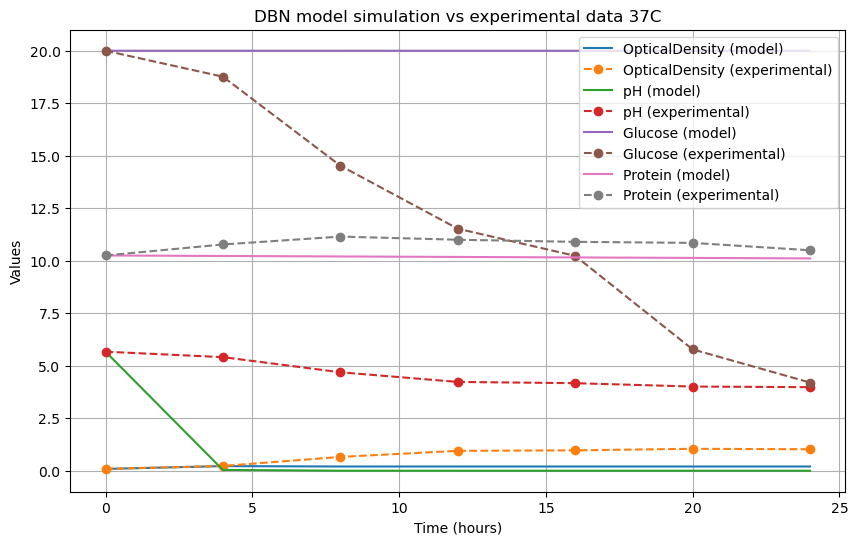

In [196]:
# Для простоти зовнішні впливи (Stirring, Aeration) поки не включаємо
params = np.random.rand(14) * 0.01

plot_model_vs_experimental(
    params,
    lb3_time_opticaldensity_ph_glucose_protein_37,
)

In [197]:
def simulate(
    params: np.ndarray,
    input_data: pd.DataFrame,
    timestamps: int,
    temperature: float = 1.0
) -> tuple[np.ndarray, ...]:
    optical_densitys, phs, glucoses, proteins = (
        [input_data["OpticalDensity"].iloc[0]],
        [input_data["pH"].iloc[0]],
        [input_data["Glucose"].iloc[0]],
        [input_data["Protein"].iloc[0]],
    )

    for _ in range(timestamps):
        optical_density, ph, glucose, protein = optical_densitys[-1], phs[-1], glucoses[-1], proteins[-1]
        optical_density_next = (
            params[0] * optical_density
            + params[1] * ph
            + params[2] * glucose
            + params[3] * protein
        ) * temperature
        ph_next = params[4] + params[5] * ph - params[6] * optical_density_next
        glucose_next = glucose - params[7] * optical_density_next
        protein_next = protein + params[8] * optical_density_next - params[9] * protein

        optical_densitys.append(optical_density_next)
        phs.append(ph_next)
        glucoses.append(glucose_next)
        proteins.append(protein_next)
    return np.array(optical_densitys), np.array(phs), np.array(glucoses), np.array(proteins)

## Optimization part

In [198]:
def normalize(
    optical_density: np.ndarray,
    ph: np.ndarray,
    glucose: np.ndarray,
    protein: np.ndarray
) -> tuple[float]:
    _std = lambda x: float(np.std(x)) if float(np.std(x)) > 0 else 1.0
    return map(_std, (optical_density, ph, glucose, protein))


def make_loss(input_data: pd.DataFrame) -> Callable:
    optical_desnity_obs = input_data["OpticalDensity"].values
    ph_obs = input_data["pH"].values
    glucose_obs = input_data["Glucose"].values
    protein_obs = input_data["Protein"].values

    std_optical_density, std_ph, std_glucose, std_protein = normalize(
        optical_desnity_obs, ph_obs, glucose_obs, protein_obs
    )

    def loss(params: np.ndarray) -> float:
        optical_density_pred, ph_pred, glucose_pred, protein_pred = simulate(
            params, input_data, _TIMESTAMPS
        )
        rX  = (optical_density_pred  - optical_desnity_obs) / std_optical_density
        rpH = (ph_pred - ph_obs) / std_ph
        rG  = (glucose_pred  - glucose_obs) / std_glucose
        rB  = (protein_pred  - protein_obs) / std_protein
        error = float(np.sum(rX**2) + np.sum(rpH**2) + np.sum(rG**2) + np.sum(rB**2))
        return error
    return loss

In [199]:
loss_func = make_loss(lb3_time_opticaldensity_ph_glucose_protein_37)
optimal_params = minimize(
    loss_func,
    params,
    method='L-BFGS-B',
    options={'maxiter': 10_000}
)
print('Optimal params:', optimal_params.x)

Optimal params: [-3.15878635e+00 -1.44878939e+00 -6.07559220e-02  9.77346183e-01
  6.46094193e+00 -7.48633832e-02  2.06349806e+00  3.50788936e+00
 -1.16542292e+00 -9.29011845e-02  8.21029162e-03  9.49666016e-03
  6.87890212e-03  6.27564776e-04]


In [200]:
def _temp_coeff_objective(
    coeffs: np.ndarray,
    nn_optimal_params: np.ndarray,
    input_data: pd.DataFrame,
    temp_labels: list[str],
    target_final_optical_density: dict[str, float]
) -> float:
    total_error = 0.0
    for i, temp_label in enumerate(temp_labels):
        coeff = coeffs[i]
        X_pred, *_ = simulate(nn_optimal_params, input_data, len(input_data) - 1, temperature=coeff)
        final_od = X_pred[-1]
        target_od = target_final_optical_density[temp_label]
        total_error += (final_od - target_od)**2
    return total_error


def optimize_temp_coefficients(
    nn_optimal_params: np.ndarray,
    input_data: pd.DataFrame,
    target_final_optical_density: dict[str, float] = {"35C": 0.98477563, "40C": 0.947898, "45C": 0.8577189},
    base_temp: str = "37C",
) -> dict[str, float]:
    temp_labels = [t for t in target_final_optical_density.keys() if t != base_temp]
    initial_coeffs = [0.5] * len(temp_labels)
    
    result = minimize(
        _temp_coeff_objective,
        initial_coeffs,
        args=(nn_optimal_params, input_data, temp_labels, target_final_optical_density),
        method='L-BFGS-B',
        bounds=[(0.1, 2.0)] * len(temp_labels)
    )
    
    coefficients = {
        temp_label: result.x[i]
        for i, temp_label in enumerate(temp_labels)
    }
    coefficients[base_temp] = 1.0
    return coefficients


optimized_temp_coeffs = optimize_temp_coefficients(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37
)

_TEMPERATURES = (
    ("35C", optimized_temp_coeffs["35C"]),
    ("37C", optimized_temp_coeffs["37C"]),
    ("40C", optimized_temp_coeffs["40C"]),
    ("45C", optimized_temp_coeffs["45C"]),
)

In [201]:
optical_density_model_temp35, pH_model_temp35, G_model_temp35, B_model_temp35 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=_TEMPERATURES[0][1]
)
optical_density_model_temp37, pH_model_temp37, G_model_temp37, B_model_temp37 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS
)
optical_density_model_temp40, pH_model_temp40, G_model_temp40, B_model_temp40 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=_TEMPERATURES[2][1]
)
optical_density_model_temp45, pH_model_temp45, G_model_temp45, B_model_temp45 = simulate(
    optimal_params.x, lb3_time_opticaldensity_ph_glucose_protein_37, _TIMESTAMPS, temperature=_TEMPERATURES[3][1]
)

In [202]:
def plot_optical_density_multi_temp(
    input_data: pd.DataFrame,
    model_curves: dict[str, np.ndarray],
    title: str = 'DBN model simulation with optimized parameters (with temperature multiplier)'
):
    time = input_data['Time'].values
    plt.figure(figsize=(10, 6))

    for label, y in model_curves.items():
        plt.plot(time, y, label=f'OpticalDensity model ({label})', marker='o')
    
    plt.plot(
        time, input_data['OpticalDensity'].values, 'o--', label='OpticalDensity experimental'
    )
    plt.legend()
    plt.xlabel('Time (hours)')
    plt.ylabel('Optical Density')
    plt.title(title)
    plt.grid()
    plt.show()

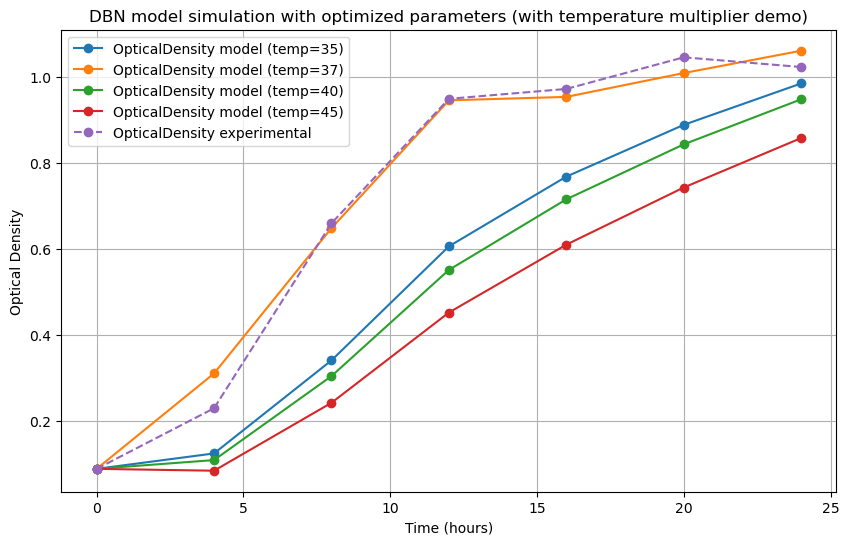

In [203]:
plot_optical_density_multi_temp(
    lb3_time_opticaldensity_ph_glucose_protein_37,
    {
        'temp=35': optical_density_model_temp35,
        'temp=37': optical_density_model_temp37,
        'temp=40': optical_density_model_temp40,
        'temp=45': optical_density_model_temp45,
    },
    title='DBN model simulation with optimized parameters (with temperature multiplier demo)'
)

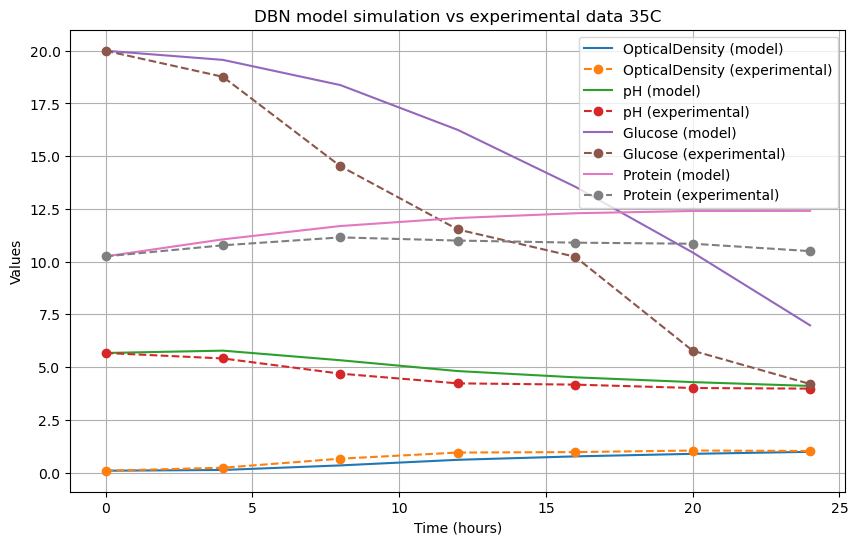

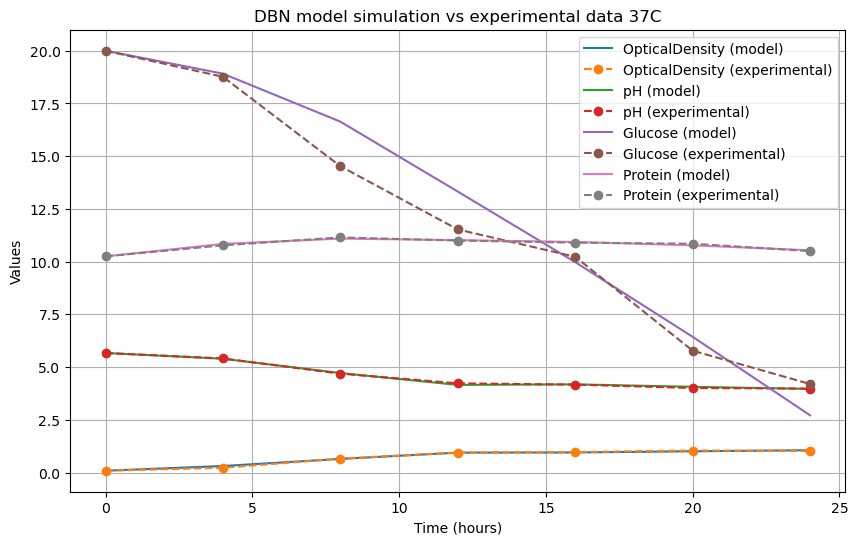

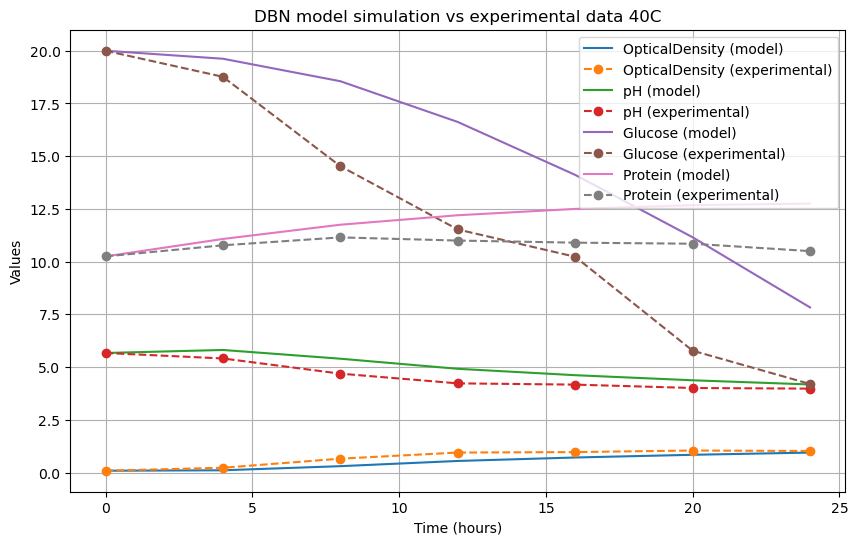

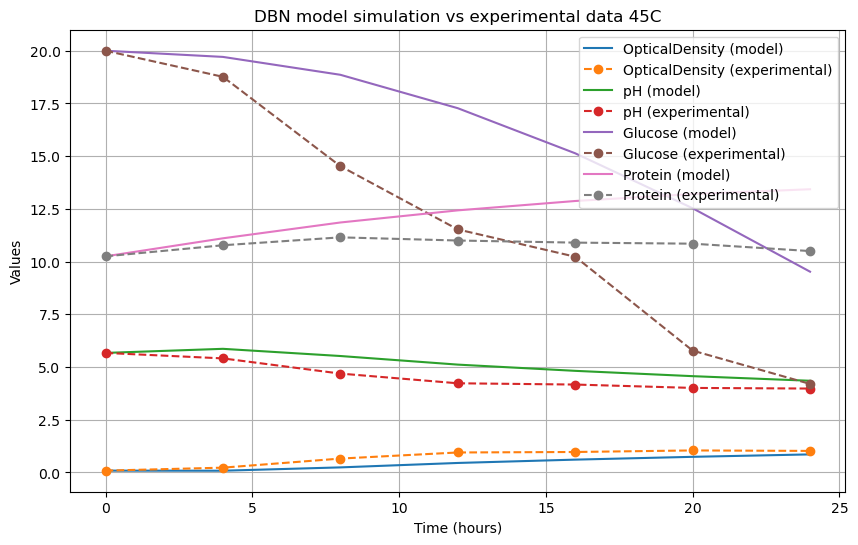

In [204]:
for label, temp_mult in _TEMPERATURES:
    plot_model_vs_experimental(
        optimal_params.x,
        lb3_time_opticaldensity_ph_glucose_protein_37,
        temp_mult=temp_mult,
        temp_label=label,
        title_prefix='DBN model simulation vs experimental data'
    )

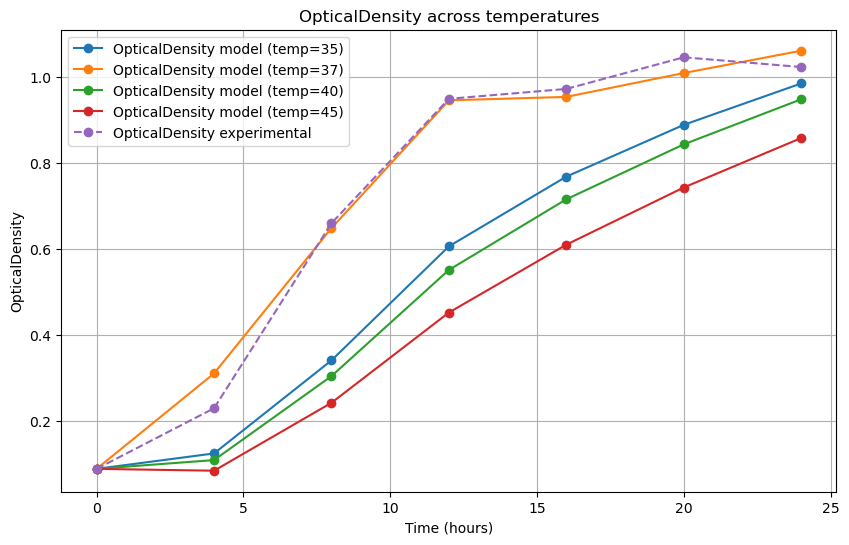

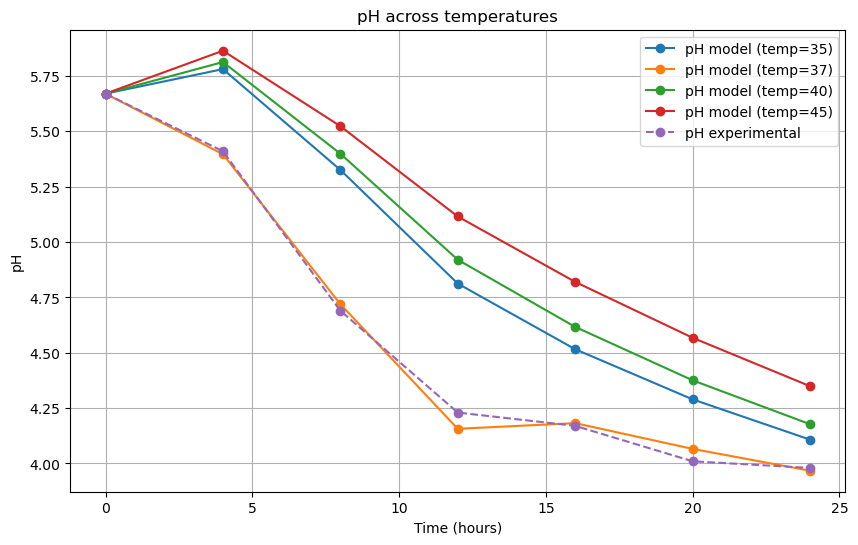

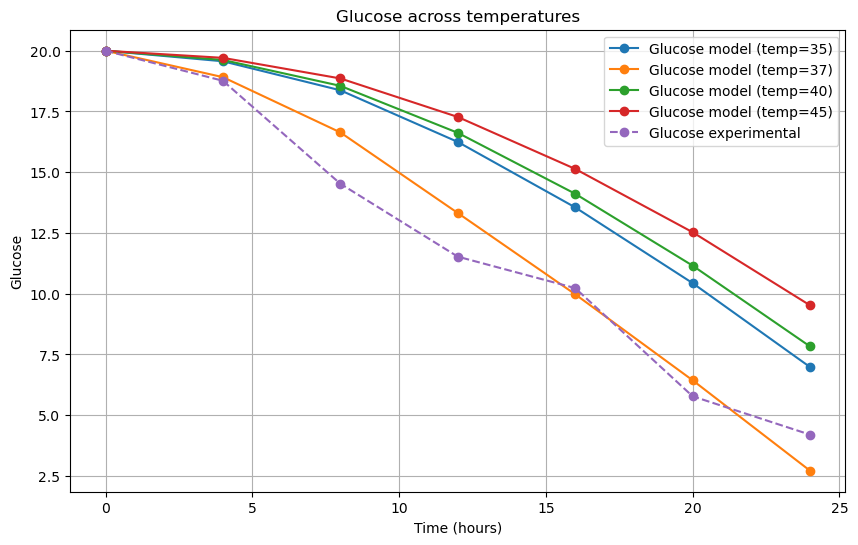

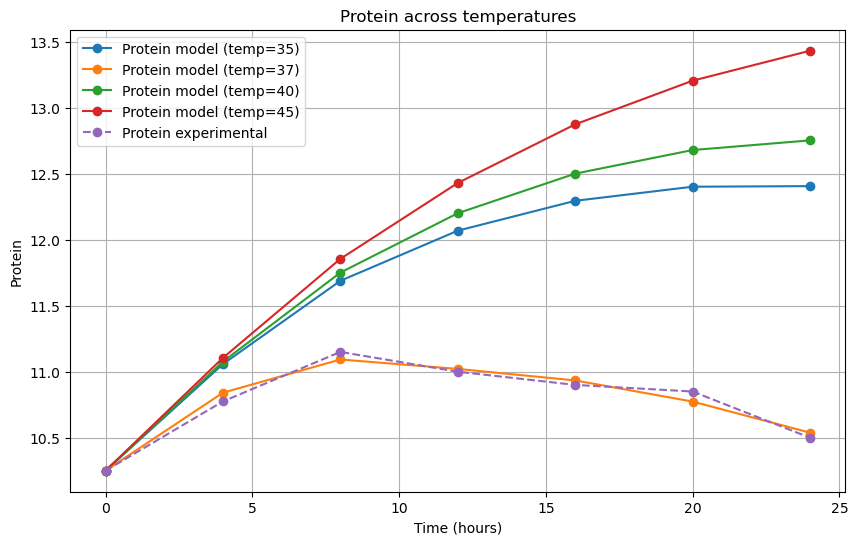

In [205]:
def plot_variable(
    input_data: pd.DataFrame,
    model_curves: dict[str, np.ndarray],
    var_label: str,
    title: str
):
    time = input_data["Time"].values
    plt.figure(figsize=(10, 6))
    
    for label, y in model_curves.items():
        plt.plot(time, y, marker="o", label=f"{var_label} model ({label})")
    
    plt.plot(time, input_data[var_label].values, "o--", label=f"{var_label} experimental")
    plt.xlabel("Time (hours)")
    plt.ylabel(var_label)
    plt.title(title or f"{var_label} across temperatures")
    plt.legend()
    plt.grid()
    plt.show()


data = {
    "OpticalDensity": {
        "temp=35": optical_density_model_temp35,
        "temp=37": optical_density_model_temp37,
        "temp=40": optical_density_model_temp40,
        "temp=45": optical_density_model_temp45,
    },
    "pH": {
        "temp=35": pH_model_temp35,
        "temp=37": pH_model_temp37,
        "temp=40": pH_model_temp40,
        "temp=45": pH_model_temp45,
    },
    "Glucose": {
        "temp=35": G_model_temp35,
        "temp=37": G_model_temp37,
        "temp=40": G_model_temp40,
        "temp=45": G_model_temp45,
    },
    "Protein": {
        "temp=35": B_model_temp35,
        "temp=37": B_model_temp37,
        "temp=40": B_model_temp40,
        "temp=45": B_model_temp45,
    },
}

for var_label, model_curves in data.items():
    plot_variable(
        lb3_time_opticaldensity_ph_glucose_protein_37,
        model_curves,
        var_label,
        title=f"{var_label} across temperatures"
    )